## Product Clustering and Sales Forecasting with Machine Learning

### Objective:
This project aims to explore and optimize sales performance by applying machine learning techniques including linear regression, KMeans clustering, and Holt-Winters forecasting. The goal is to segment products based on profitability and sales trends, and accurately forecast future revenue using time series analysis — enabling strategic business decisions in pricing, inventory, and marketing.

### Dataset Link: https://www.kaggle.com/datasets/laibaanwer/superstore-sales-dataset 

### Key Insight:

##### Discounts Have a Negative Impact on Profit

* From linear regression analysis, I found that increasing discounts significantly reduces profit.
* Each 1% increase in discount leads to an average profit reduction of approximately $2.60.
* This suggests that over-discounting can harm profitability, and discount strategies should be optimized based on product margins.

##### Product Segmentation Reveals 3 Key Clusters

* Using KMeans clustering on sales and profit, I identified 3 product clusters:
* Low sales, low profit – candidates for removal or heavy promotion
* High sales, low profit – need pricing or cost optimization
* High sales, high profit – likely best-sellers with healthy margins

##### Future Sales Show an Upward Trend with Seasonality

* Holt-Winters Forecasting revealed a clear upward sales trend, with predictable monthly seasonality.
* Sales are expected to peak around mid-year (May–June) and drop slightly in Q1.
* This insight is critical for resource planning, procurement, and budgeting in advance.

### Import Library

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Load and Data Inspection

In [2]:
# 2. Load data
df = pd.read_csv(
    'superstorefix.csv',
    sep=';',
    encoding='utf-8'
)

In [3]:
df.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,01/01/2011,06/01/2011,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,...,Office Supplies,Storage,"Tenex Lockers, Blue",408,2.0,0%,106.140,35.46,Medium,2011.0
1,IN-2011-47883,01/01/2011,08/01/2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3.0,10%,36.036,9.72,Medium,2011.0
2,HU-2011-1220,01/01/2011,05/01/2011,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,...,Office Supplies,Storage,"Tenex Box, Single Width",66,4.0,0%,29.640,8.17,High,2011.0
3,IT-2011-3647632,01/01/2011,05/01/2011,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,...,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3.0,50%,-26.055,4.82,High,2011.0
4,IN-2011-47883,01/01/2011,08/01/2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5.0,10%,37.770,4.70,Medium,2011.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   segment         51290 non-null  object 
 6   state           51290 non-null  object 
 7   country         51290 non-null  object 
 8   market          51290 non-null  object 
 9   region          51290 non-null  object 
 10  product_id      51290 non-null  object 
 11  category        51290 non-null  object 
 12  sub_category    51290 non-null  object 
 13  product_name    51290 non-null  object 
 14  sales           51284 non-null  object 
 15  quantity        51284 non-null  float64
 16  discount        51284 non-null  object 
 17  profit          51284 non-null 

### Data Cleaning

In [5]:
num_rows = len(df)
num_rows

51290

In [6]:
#Check Missing Values
missing = df.isna().sum()
print(missing)
#Check Duplicate Values
duplicates = df.duplicated()
print(duplicates)

order_id          0
order_date        0
ship_date         0
ship_mode         0
customer_name     0
segment           0
state             0
country           0
market            0
region            0
product_id        0
category          0
sub_category      0
product_name      0
sales             6
quantity          6
discount          6
profit            6
shipping_cost     6
order_priority    6
year              6
dtype: int64
0        False
1        False
2        False
3        False
4        False
         ...  
51285    False
51286    False
51287    False
51288    False
51289    False
Length: 51290, dtype: bool


In [7]:
df = df.dropna(subset=['sales','quantity','discount','profit','shipping_cost','order_priority'])

In [8]:
df = df.drop_duplicates()

In [9]:
#Drop Irrelevant Columns
df = df.drop(columns=['year'])

In [10]:
#Change Date Format
df = df.sort_values('order_date')
df['order_date'] = pd.to_datetime(df['order_date'], format='%d/%m/%Y', errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], format='%d/%m/%Y', errors='coerce')

In [11]:
print(df.dtypes[['order_date','ship_date']])

order_date    datetime64[ns]
ship_date     datetime64[ns]
dtype: object


In [12]:
#Change Numeric Format
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
df['discount'] = pd.to_numeric(df['discount'].str.rstrip('%'), errors='coerce') / 100

In [13]:
print(df.dtypes[['sales','discount']])

sales       float64
discount    float64
dtype: object


### Exploratory Data Analysis

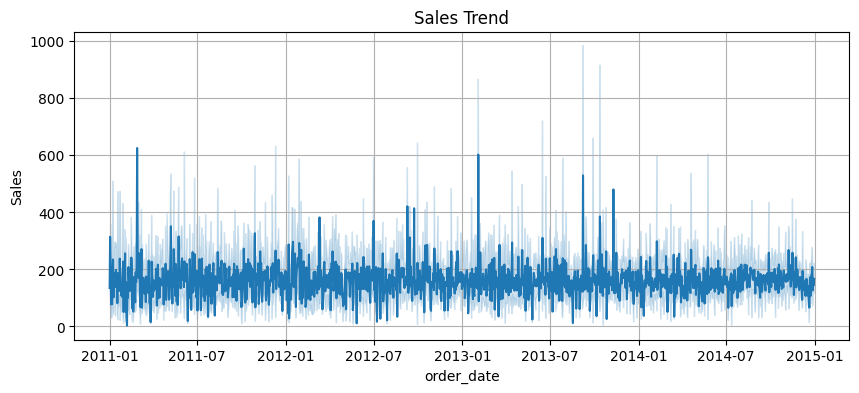

In [14]:
# 1. Sales Trend Over Time
plt.figure(figsize=(10, 4))
sns.lineplot(x='order_date', y='sales', data=df)
plt.title('Sales Trend')
plt.ylabel('Sales')
plt.grid()
plt.show()

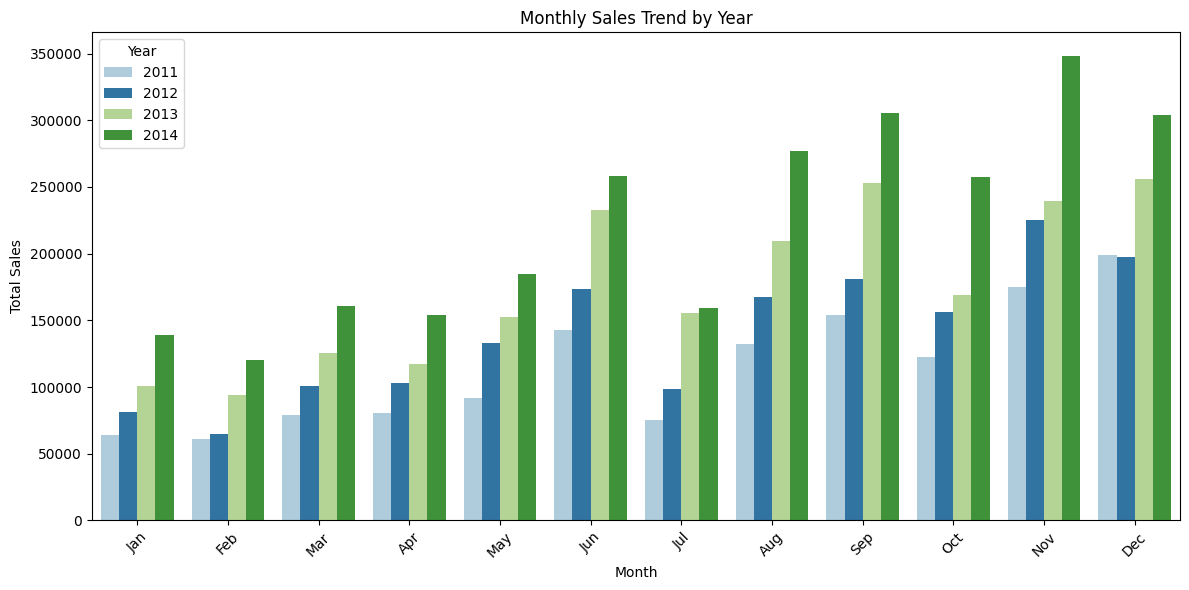

In [15]:
# 2. Monthly Sales Trend Year

# Extract Year and Month
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month

# Aggregate monthly sales
monthly_sales = df.groupby(['Year', 'Month'])['sales'].sum().reset_index()

# Convert month number to month name
import calendar
monthly_sales['Month Name'] = monthly_sales['Month'].apply(lambda x: calendar.month_abbr[x])

# Sort months in order (Jan to Dec)
month_order = list(calendar.month_abbr)[1:]  

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sales,
    x='Month Name',
    y='sales',
    hue='Year',
    order=month_order,
    palette='Paired'
)
plt.title('Monthly Sales Trend by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

####  Observations and Trends from Monthly Sales (2011–2014)

#####  General Sales Growth
- **2011**: Lowest sales across all years.
- **2012**: Better than 2011, but still behind 2013 and 2014.
- **2013**: Strong growth compared to previous years.
- **2014**: Highest overall sales, showing steady growth.

#####  Monthly Sales Pattern
- **Jan–Feb**: Sales are consistently low.
- **March**: Noticeable increase in sales.
- **April–June**: Sales steadily rise, with **June** being the strongest month in the first half.
- **July–Sept**: Sales stay high with small fluctuations.
- **Oct–Dec**: Sales peak in **November**, followed by high **December** numbers.

#####  Peak Sales Months
- **November**: Highest sales month every year.
- **December**: Second highest, especially strong in 2014.
- **June**: Strong mid-year sales.

#####  Seasonal Trends
- **Low Season**: January and February show consistent dips.
- **High Season**: October to December show high performance, likely due to holidays.

#####  Year-over-Year Comparison
- Sales improved **each year** from 2011 to 2014.
- Growth was especially sharp from 2012 to 2013, and continued into 2014.

---

#####  Key Insights
-  **Upward Trend**: Sales increased consistently from 2011 to 2014.
-  **Seasonality**: Clear peaks in Nov–Dec, dips in Jan–Feb.
-  **Best Month**: November consistently leads in sales.
-  **Planning Opportunity**: Use these trends for inventory, marketing, and budget planning.



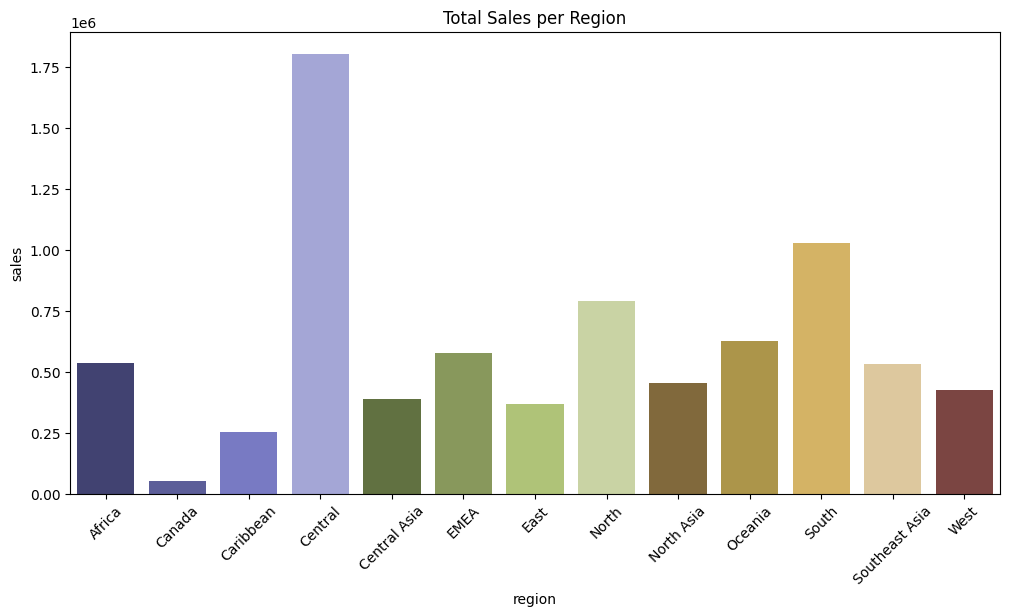

In [16]:
# Sales dan Profit per Region
plt.figure(figsize=(12, 6))

agg = df.groupby('region')[['sales','profit']].sum().reset_index()
sns.barplot(x='region', y='sales', data=agg, palette='tab20b', hue='region')
plt.title('Total Sales per Region'); plt.xticks(rotation=45); plt.show()


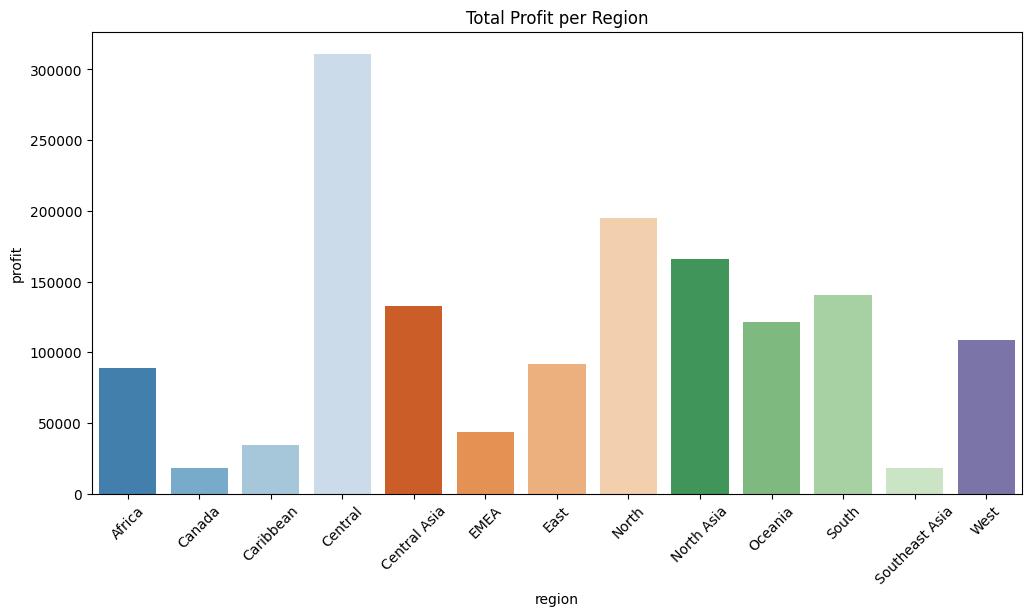

In [17]:
plt.figure(figsize=(12, 6))


sns.barplot(x='region', y='profit', data=agg, palette='tab20c', hue='region')
plt.title('Total Profit per Region'); plt.xticks(rotation=45); plt.show()

####  Analysis of Sales and Profit by Region

#####  Chart 1: Total Sales per Region
- **Top Performer**:  *Central* region has the highest sales by far.
- **Runner-Up**:  *South* region follows, with around 1 million in sales.
- **Mid-Range Regions**: 
  - *North*, *EMEA*, *Oceania*, and *West* show moderate sales (around 0.75 million).
- **Low Performers**: 
  - *Canada* and *Southeast Asia* have the lowest sales.
  - *Caribbean* and *East* also perform poorly.

#####  Chart 2: Total Profit per Region
- **Top Profit Region**: *Central* also leads in profit.
- **Second-Highest Profit**: *North*, followed closely by *South*.
- **Moderate Profit Regions**: 
  - *North Asia*, *Oceania*, *West*, *EMEA*, and *Central Asia*.
- **Low Profit Regions**: 
  - *Southeast Asia*, *Canada*, *Caribbean*, and *East*.

#####  Comparison Between Sales and Profit
- **Strong Correlation**: *Central* region dominates both sales and profit.
- **Interesting Cases**:
  - *South* has high sales but lower profit than *North* → May have lower margins or higher costs.
  - *EMEA* and *Central Asia* have decent sales but weak profit → Possibly inefficient operations.
- **Underperformers**: *Southeast Asia*, *Canada*, *Caribbean*, *East* are weak in both charts.

---

#####  Key Insights
- ** Central is the strongest region** in both sales and profit.
- ** South region has high sales, but profit needs improvement**—check pricing, discounts, or cost structure.
- ** Underperformers need support** (e.g. *Southeast Asia*, *Canada*) through marketing or operational changes.
- ** Mid-range performers** like *North*, *Oceania*, and *West* can be optimized further.

---

#####  Recommendations
- ** Focus on Central**: Learn from its success and apply across regions.
- ** Improve profit in South**: Review profit levers to match its strong sales.
- ** Boost weak regions**: Launch targeted improvements in underperforming regions.
- ** Optimize middle-tier**: Support mid-range regions to push them into top performance.


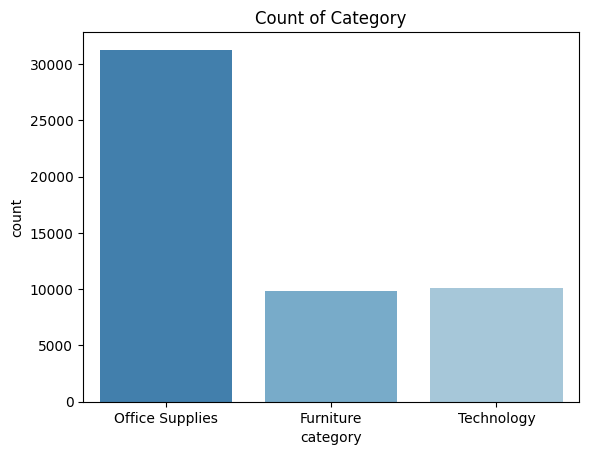

In [18]:
sns.countplot(x='category', palette='tab20c', hue='category', data=df)
plt.title('Count of Category')
plt.show()


#####  Chart Title: "Count of Category"

#####  Observations:
- Office Supplies:
  - Has the **highest count**, around **31,000**
  - Clearly dominates the other categories

- Furniture:
  - Moderate count, around **10,000**

- Technology:
  - Similar to Furniture, also around **10,000**

---

#####  Key Insights:
- **Office Supplies** has more than **3x the count** compared to both Furniture and Technology.
- **Furniture and Technology** categories are **very close in volume**, suggesting similar demand or inventory levels.


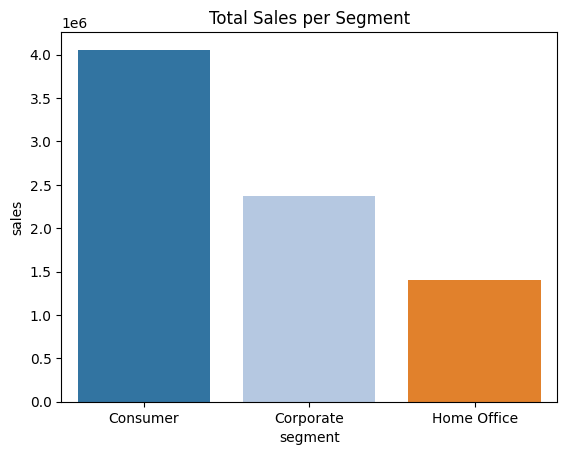

In [19]:
seg = df.groupby('segment')['sales'].sum().reset_index()
sns.barplot(x='segment', y='sales', data=seg, palette='tab20', hue='segment')
plt.title('Total Sales per Segment'); plt.show()

####  Total Sales per Segment Analysis

#####  Observations:
- Consumer:
  - Highest sales, around **4,000,000**
  - Dominates the chart and contributes the most to revenue

- Corporate:
  - Second place with about **2,500,000** in sales
  - Has potential for further growth

- Home Office:
  - Lowest sales, around **1,500,000**
  - Underperforming compared to other segments

---

#####  Key Insights:
- **Consumer** segment leads strongly, suggesting high demand or effective outreach to individuals.
- **Corporate** performs well but could be expanded with better B2B strategies.
- **Home Office** is the weakest segment and may need a focused strategy to boost performance.



### Linear Regression

In [20]:
# 3. Linear Regression: Profit ~ Discount
X = df[['discount']]  # variabel independen
y = df['profit']      # target
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(f"Coef: {model.coef_[0]:.4f}, Intercept: {model.intercept_:.2f}")
print(f"R²: {r2_score(y, y_pred):.3f}, MSE: {mean_squared_error(y, y_pred):.2f}")

Coef: -259.9679, Intercept: 65.78
R²: 0.100, MSE: 27380.61


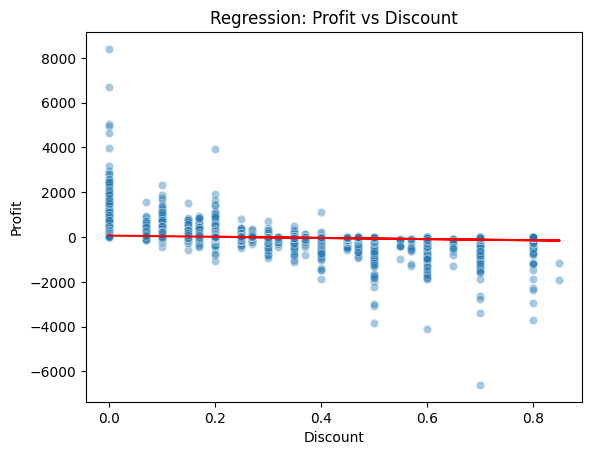

In [21]:
# Plot scatter + regression line
sns.scatterplot(x='discount', y='profit', data=df, alpha=0.4)
plt.plot(df['discount'], y_pred, color='red')
plt.title('Regression: Profit vs Discount')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()

##### Interpretation

* The model suggests that for every 1% increase in discount, profit decreases by approximately $2.60 on average.

* The R² value of 0.10 indicates a weak relationship, meaning other factors likely influence profit as well (e.g., cost structure, product category, logistics).

##### Business Insight:

* Excessive discounts may erode profit margins. Businesses should optimize discount strategies to balance volume and profitability.

### K-Means Clustering

In [22]:
# Create features
clust = df[['sales', 'profit']].dropna()

In [23]:
# Standardize features to balance the scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust)

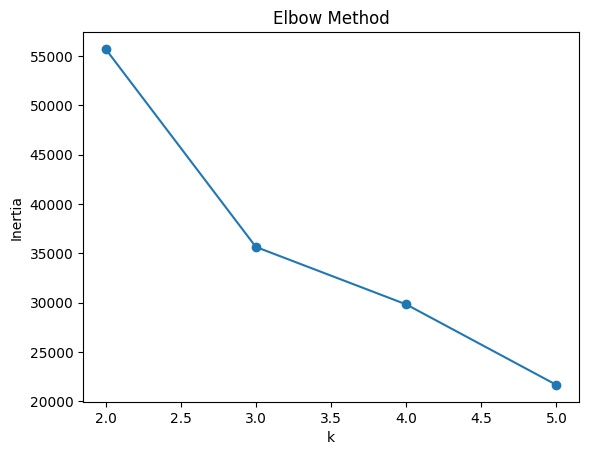

In [24]:
# Elbow method for k
sse = []
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2,6), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [25]:
# Based on elbow (k=3), run clustering
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, init='k-means++', random_state=42)
clust['cluster'] = kmeans.fit_predict(X_scaled)

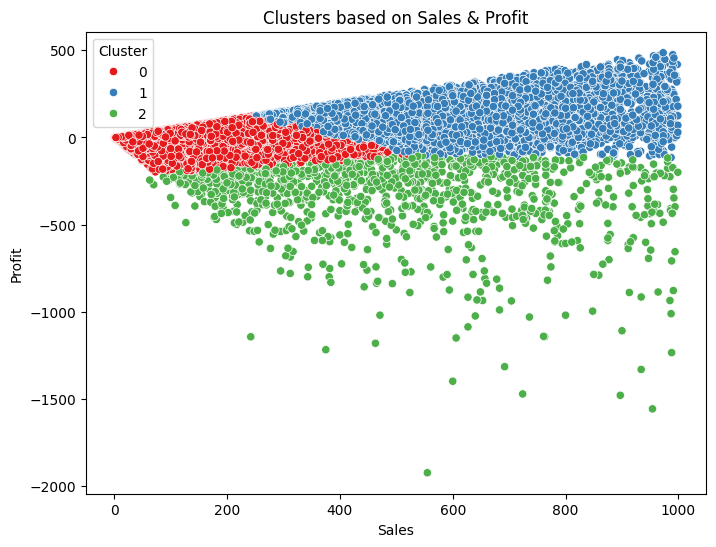

In [26]:
# Visualize clustering results
plt.figure(figsize=(8,6))
sns.scatterplot(data=clust, x='sales', y='profit', hue='cluster', palette='Set1')
plt.title('Clusters based on Sales & Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.legend(title='Cluster')
plt.show()

In [27]:
# Combine with product name to see details per cluster
result = df[['product_name', 'sales', 'profit']].join(clust['cluster'])

In [28]:
# Display the clustering results table
display(result.sort_values('cluster').head(10))  # show first 10

,product_name,sales,profit,cluster
38255,Logitech B530 USB Headset - headset - Full siz...,30.0,2.5893,0.0
14563,"HP Fax and Copier, Digital",173.0,86.2500,0.0
27211,"Jiffy Peel and Seal, with clear poly window",28.0,-48.0600,0.0
27212,"Green Bar Note Cards, Premium",125.0,26.1600,0.0
27210,"Acco Index Tab, Clear",36.0,-2.1930,0.0
27198,"Epson Printer, Red",260.0,54.5400,0.0
27214,"Stockwell Thumb Tacks, Bulk Pack",66.0,16.3500,0.0
27209,"Deflect-O Clock, Erganomic",49.0,4.3800,0.0
27215,"Boston Sketch Pad, Easy-Erase",98.0,28.3200,0.0
27213,"Eaton Memo Slips, 8.5 x 11",60.0,4.1000,0.0


##### Features used:

* Sales and Profit
* Optimal number of clusters: 3 (based on Elbow Method)

##### Interpretation:

* Cluster 0 (Low Sales – Low Profit): Underperforming products that may need discontinuation or pricing review.

* Cluster 1 (High Sales – High Profit): Star products with strong performance — ideal for scaling and promotional campaigns.

* Cluster 2 (High Sales – Low Profit): High-volume but low-margin products. Could signal over-discounting or high fulfillment costs.

##### Business Insight:

* This segmentation enables smarter decisions on which products to boost, restructure, or phase out.

### Forecast 

### Moving Average

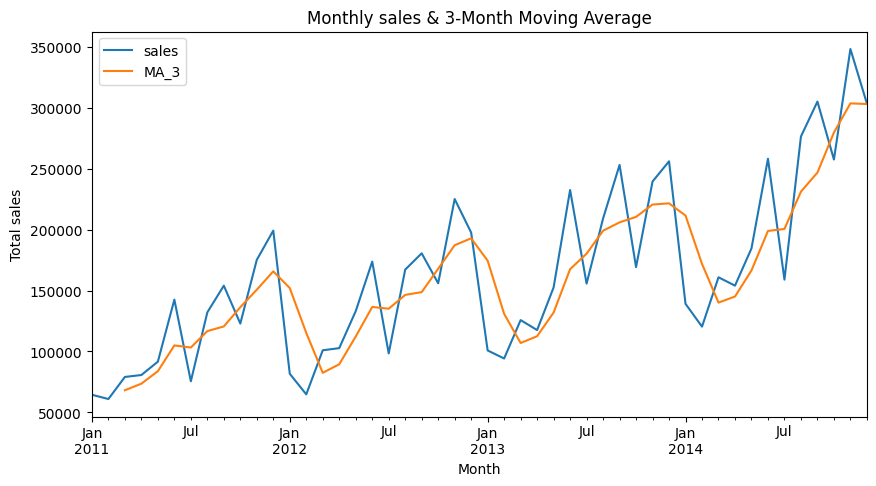

In [29]:
#  Moving Average Forecast: monthly profit
df_ts = df.set_index('order_date').resample('M')['sales'].sum().to_frame()
df_ts['MA_3'] = df_ts['sales'].rolling(window=3).mean()

df_ts.plot(figsize=(10,5))
plt.title('Monthly sales & 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('Total sales')
plt.show()

### Exponential Smoothing

In [30]:
df['order_date'] = pd.to_datetime(df['order_date'])
df.set_index('order_date', inplace=True)
sales_monthly = df['sales'].resample('M').sum()

C:\Users\dimas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


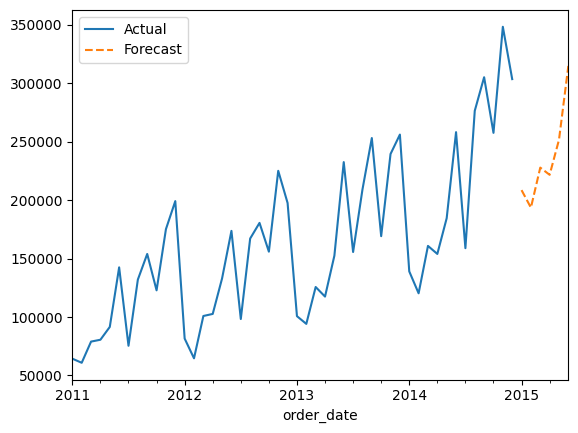

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(sales_monthly, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()
forecast = fit.forecast(6)

sales_monthly.plot(label='Actual')
forecast.plot(label='Forecast', linestyle='--')
plt.legend()
plt.show()

C:\Users\dimas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


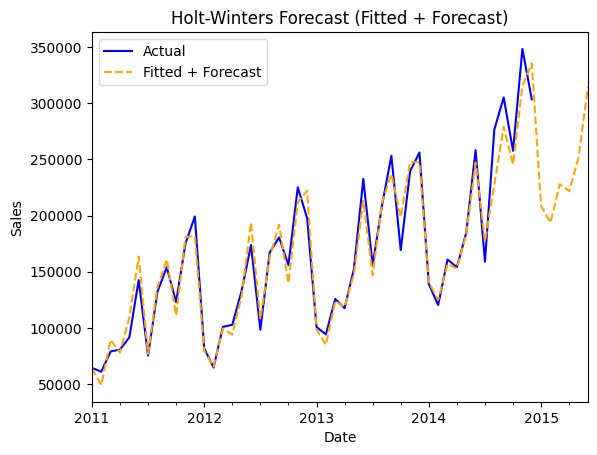

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# Model
model = ExponentialSmoothing(sales_monthly, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Fitted + forecast
fitted = fit.fittedvalues
forecast = fit.forecast(6)
combined = pd.concat([fitted, forecast])

# Plot
sales_monthly.plot(label='Actual', color='blue')
combined.plot(label='Fitted + Forecast', color='orange', linestyle='--')
plt.legend()
plt.title("Holt-Winters Forecast (Fitted + Forecast)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [33]:
# Create a DataFrame for forecast results
forecast_df = pd.DataFrame({
    'Date': forecast.index,
    'Forecasted_Sales': forecast.values
})

# Reset index so that date becomes a regular column (not index)
forecast_df = forecast_df.reset_index(drop=True)

# Show table
print(forecast_df)

        Date  Forecasted_Sales
0 2015-01-31     208636.070613
1 2015-02-28     193633.065570
2 2015-03-31     227894.634965
3 2015-04-30     221744.927453
4 2015-05-31     251732.059183
5 2015-06-30     314938.529009


##### Interpretation

* Forecast indicates clear seasonality with a gradual upward trend peaking around June 2015.

* This suggests cyclical buying patterns, likely tied to seasonal promotions or events.

##### Business Insight:

* Forecast results can guide supply planning, budget allocation, and campaign timing for peak months.